In [1]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing all the important libraries

In [13]:
#import libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [3]:
# Defining the path for train and test images
path_to = """/content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration"""
train_set = pathlib.Path(path_to+"/Train/")
test_set = pathlib.Path(path_to+"/Test/")

In [8]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(train_set.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(test_set.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Create a dataset
Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
#Train datset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_set,batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               label_mode='categorical',
                                                              seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
#Validation Dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(train_set,batch_size=batch_size,
                                                            image_size=(img_height,img_width),
                                                            label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
#All the classes of skin cancer.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualizing Data

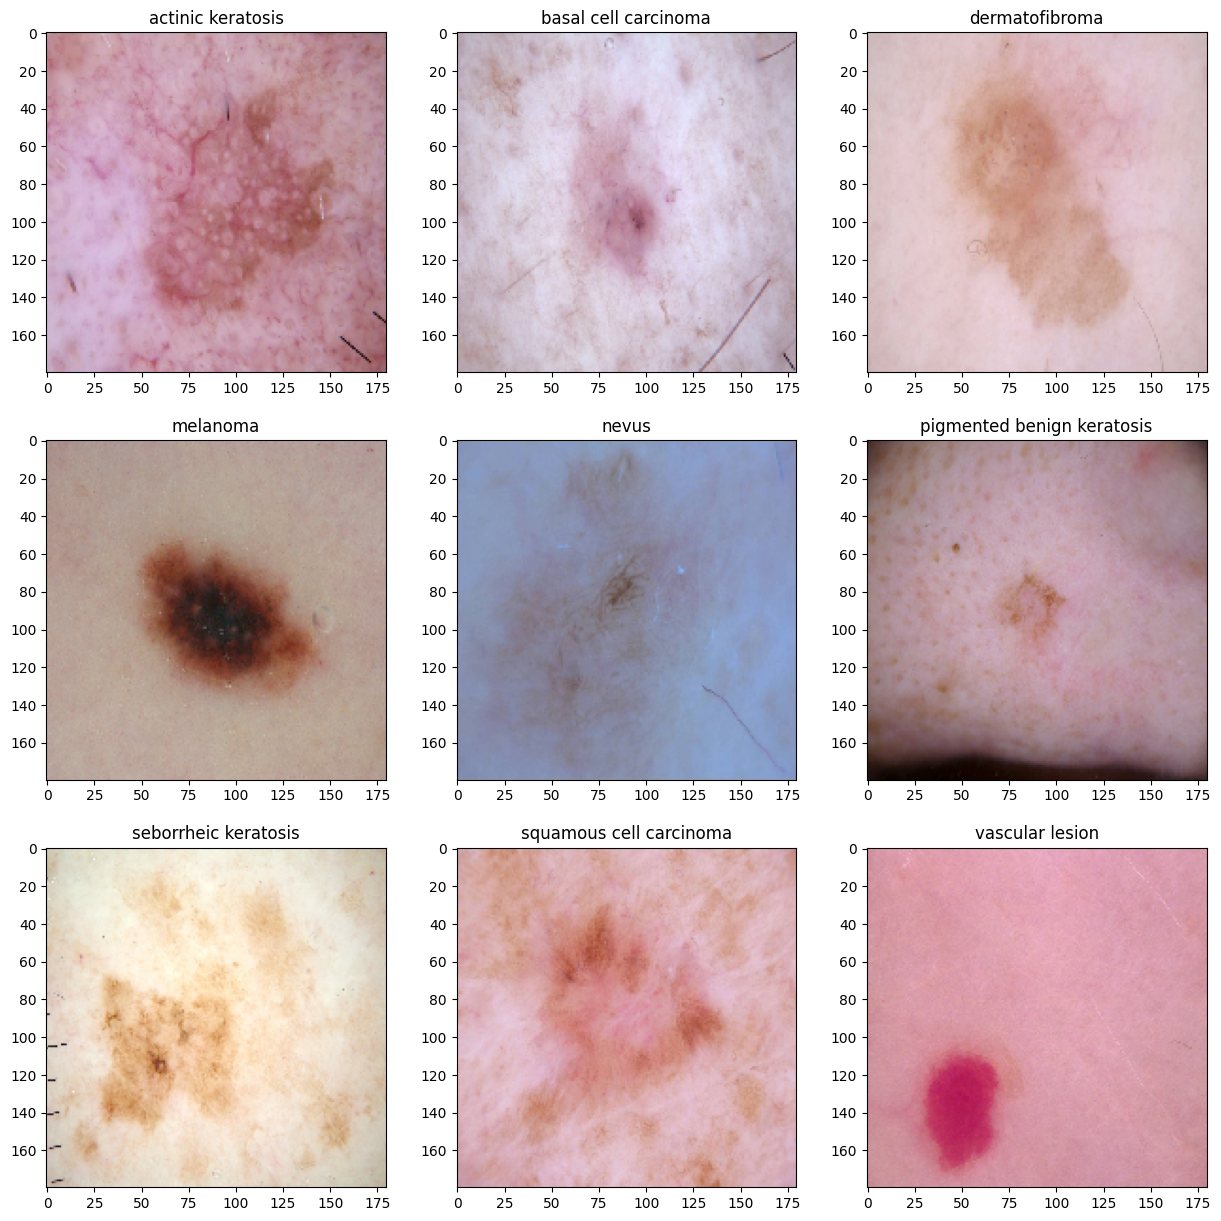

In [ ]:
#Visualize one instance of all the class present in the dataset.
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(train_set)+'/'+c+'/'+x,os.listdir(str(train_set)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

## Model Building

In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture
input_shape = (img_height,img_width,3)

#Sequential allows you to create models layer-by-layer
model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [ ]:
# summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

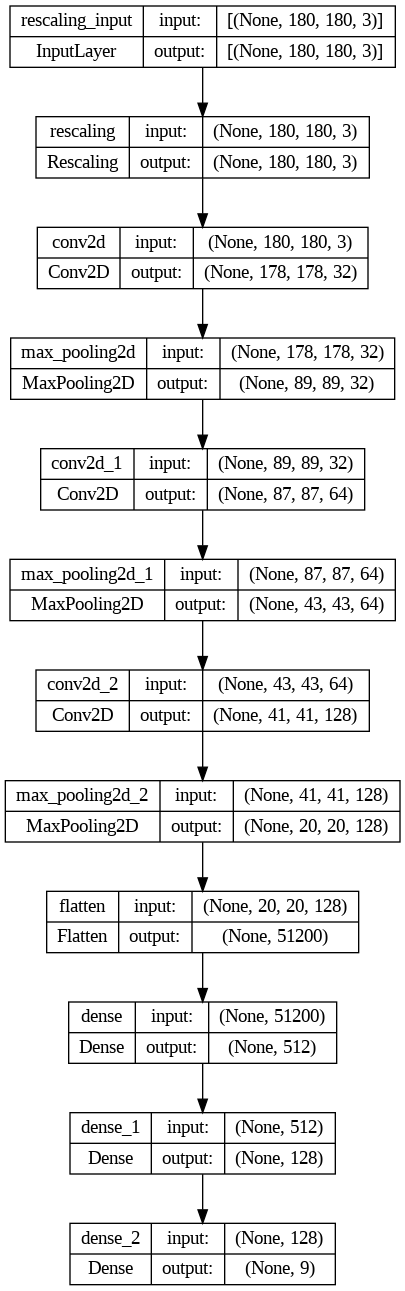

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0057 - accuracy: 0.2612
Epoch 1: val_accuracy improved from -inf to 0.41387, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 472s 4s/step - loss: 2.0057 - accuracy: 0.2612 - val_loss: 1.7184 - val_accuracy: 0.4139
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.5622 - accuracy: 0.4408
Epoch 2: val_accuracy improved from 0.41387 to 0.52573, saving model to model.h5
56/56 [==============================] - 140s 2s/step - loss: 1.5622 - accuracy: 0.4408 - val_loss: 1.4244 - val_accuracy: 0.5257
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.4393 - accuracy: 0.4961
Epoch 3: val_accuracy did not improve from 0.52573
56/56 [==============================] - 139s 2s/step - loss: 1.4393 - accuracy: 0.4961 - val_loss: 1.4556 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.3170 - accuracy: 0.5329
Epoch 4: val_accuracy did not improve from 0.52573
56/56 [==============================] - 142s 3s/step - loss: 1.3170 - accuracy: 0.5329 - val_loss: 1.3773 - val_accuracy: 0.5145
Epoch 5/20
56/5

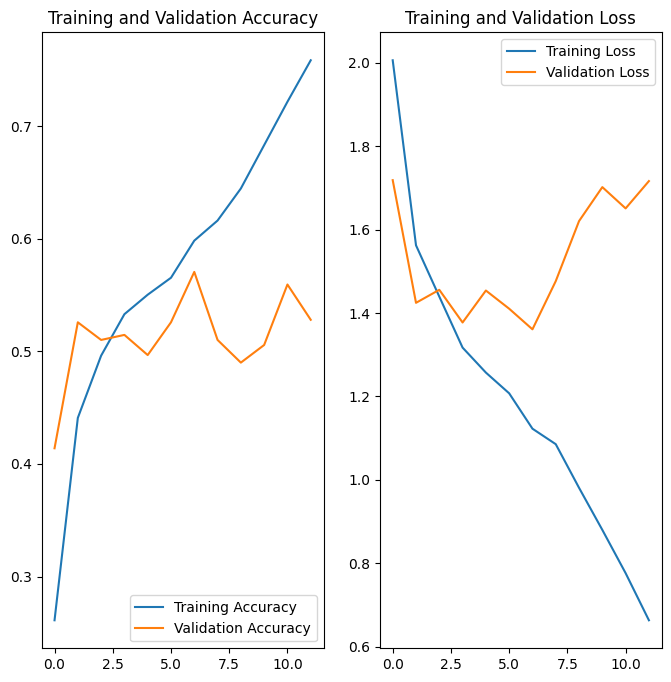

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Model is overfitting. From the above Training vs Validation accuracy graph we can see that as the epoch increases the difference between Training accuracy and validation accuracy increases.

In [ ]:
#Data augumentation strategy.

rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),

  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),

  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

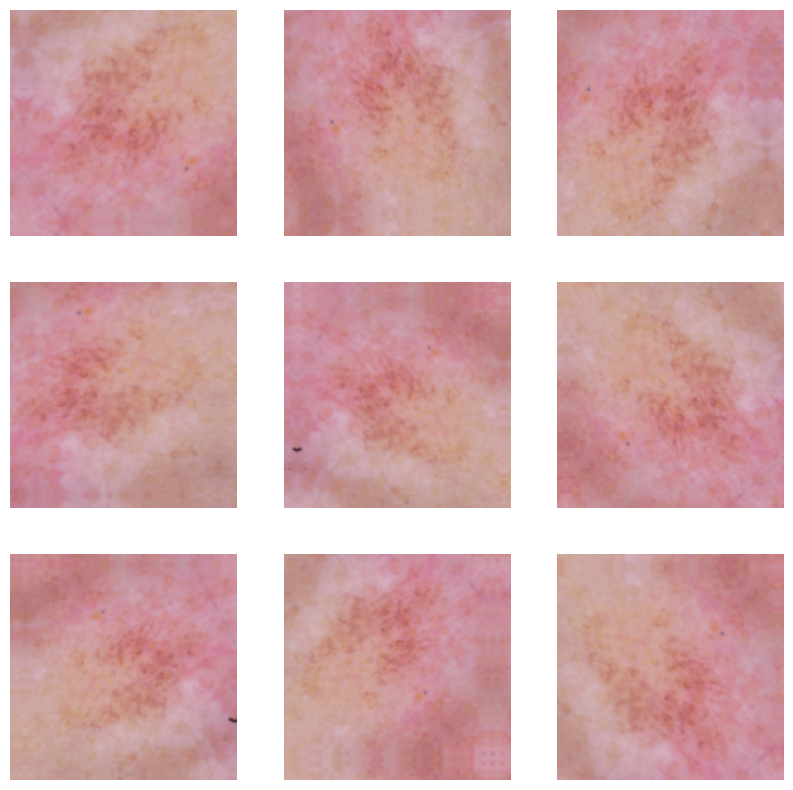

In [ ]:
#Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
## Model 2 Creation

#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.


## Your code goes here
model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.
model2.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 20
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.2623 - accuracy: 0.1998
Epoch 1: val_accuracy improved from -inf to 0.26174, saving model to model.h5
56/56 [==============================] - 169s 3s/step - loss: 2.2623 - accuracy: 0.1998 - val_loss: 2.1642 - val_accuracy: 0.2617
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 2.0545 - accuracy: 0.1942
Epoch 2: val_accuracy improved from 0.26174 to 0.28188, saving model to model.h5
56/56 [==============================] - 161s 3s/step - loss: 2.0545 - accuracy: 0.1942 - val_loss: 2.0056 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.9464 - accuracy: 0.2617
Epoch 3: val_accuracy improved from 0.28188 to 0.40045, saving model to model.h5
56/56 [==============================] - 163s 3s/step - loss: 1.9464 - accuracy: 0.2617 - val_loss: 1.8442 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.8144 - accuracy: 0

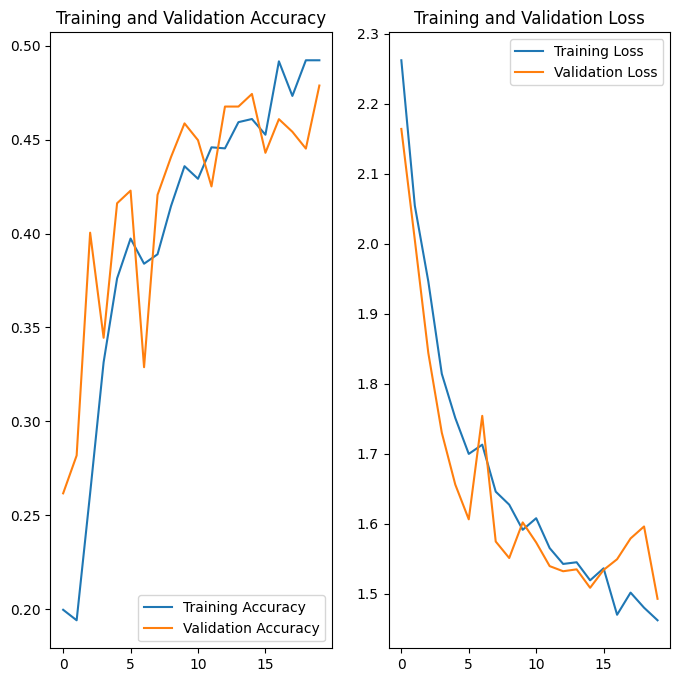

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* After using data augumentation and dropout layer overfitting issue is reduce.

* Model Performance is still not increased. Will check the distribution of classes in the training set to check is there have class imbalance.

## Visualizing class distribution

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

In [ ]:
# Checking class distribution
class_dist =  class_distribution_count(train_set)
class_dist

,Class,No. of Image
0,actinic keratosis,114
1,vascular lesion,139
2,basal cell carcinoma,376
3,dermatofibroma,95
4,pigmented benign keratosis,462
5,seborrheic keratosis,77
6,nevus,357
7,melanoma,438
8,squamous cell carcinoma,181


<Axes: xlabel='No. of Image', ylabel='Class'>

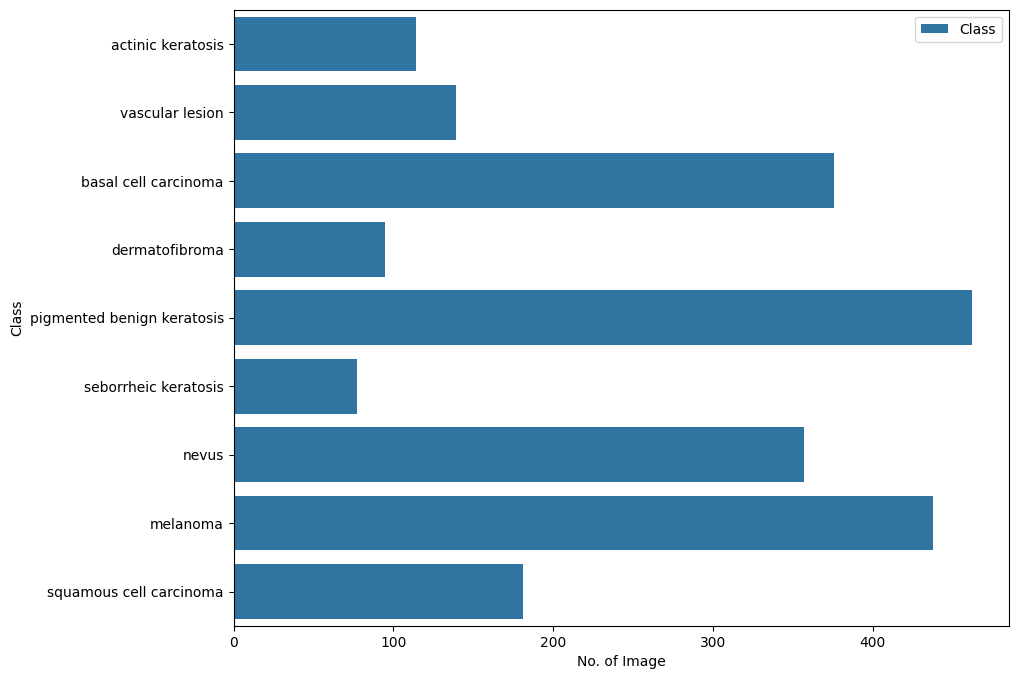

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=class_dist,
            label="Class")

*  seborrheic keratosis has the least number of samples only 77.

* pigmented benign keratosis (462 Samples), melanoma (438 Samples), basal cell carcinoma (376 Samples), and nevus (357 Samples) classes dominates the data in terms proportionate number of samples .

There is a class imbalance to solve this using a python package Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [6]:
#install Augmentor
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

* Instantiate a Pipeline object pointing to a directory containing your initial image data set.
* Define a number of operations to perform on this data set using your Pipeline object.
* Execute these operations by calling the Pipeline’s sample() method.

In [12]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to+"/Train/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B2728F460>: 100%|██████████| 500/500 [00:29<00:00, 16.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B270AAA70>: 100%|██████████| 500/500 [00:26<00:00, 18.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5BADE87460>: 100%|██████████| 500/500 [00:24<00:00, 20.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F5B2730EE00>: 100%|██████████| 500/500 [02:06<00:00,  3.96 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F5B2712BAF0>: 100%|██████████| 500/500 [01:53<00:00,  4.41 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5BAED72AD0>: 100%|██████████| 500/500 [00:26<00:00, 18.89 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5B2723D6C0>: 100%|██████████| 500/500 [00:49<00:00, 10.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5B2711F1F0>: 100%|██████████| 500/500 [00:24<00:00, 20.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/MS in AI & ML/Assignments/Melanoma Skin Cancer Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B273125C0>: 100%|██████████| 500/500 [00:24<00:00, 20.32 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(train_set.glob('*/output/*.jpg')))
print(image_count_train)

4500


**see the distribution of augmented data after adding new images to the original training data.**

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(train_set, '*','output', '*.jpg'))]
#path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_set, '*','output', '*.jpg'))]
#lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
#dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [ ]:
#label count.
df2['Label'].value_counts()

actinic keratosis             500
vascular lesion               500
basal cell carcinoma          500
dermatofibroma                500
pigmented benign keratosis    500
seborrheic keratosis          500
nevus                         500
melanoma                      500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


## Create a training dataset

In [ ]:
#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to+"/Train",
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## Create a validation dataset

In [14]:
#validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to+"/Train",
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
#Model 3

model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.
model3.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
epochs = 50
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
281/281 [==============================] - 22s 61ms/step - loss: 2.2247 - accuracy: 0.2313 - val_loss: 4.0320 - val_accuracy: 0.1348
Epoch 2/50
281/281 [==============================] - 17s 59ms/step - loss: 1.6469 - accuracy: 0.3792 - val_loss: 2.0149 - val_accuracy: 0.3453
Epoch 3/50
281/281 [==============================] - 16s 58ms/step - loss: 1.4444 - accuracy: 0.4553 - val_loss: 1.5554 - val_accuracy: 0.3703
Epoch 4/50
281/281 [==============================] - 16s 59ms/step - loss: 1.3135 - accuracy: 0.4949 - val_loss: 1.5015 - val_accuracy: 0.4001
Epoch 5/50
281/281 [==============================] - 16s 58ms/step - loss: 1.2220 - accuracy: 0.5364 - val_loss: 1.3219 - val_accuracy: 0.4927
Epoch 6/50
281/281 [==============================] - 16s 58ms/step - loss: 1.0655 - accuracy: 0.6014 - val_loss: 1.2252 - val_accuracy: 0.5260
Epoch 7/50
281/281 [==============================] - 16s 58ms/step - loss: 1.0103 - accuracy: 0.6284 - val_loss: 1.3851 - val_accuracy:

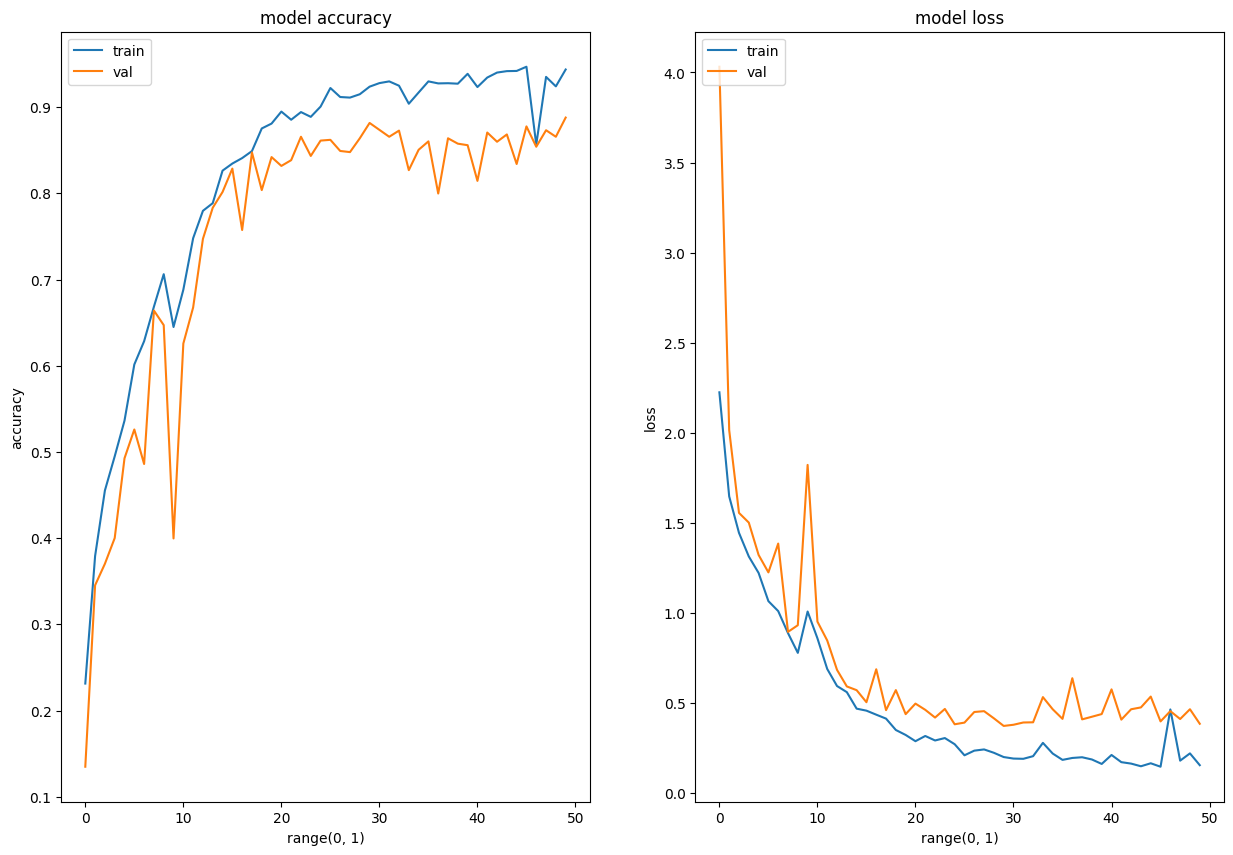

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

* As per the final model (model3) Training accuracy and validation accuracy increases.
* Model overfitting issue is solved.
* Class rebalance helps in augmentation and achieving the best Training and validation accuracy.